## **STAT 430 Final Project**

> Author: **Lucas Nelson**

> Date: **TBD**

Soccer analytics is a growing field that many clubs invest a great deal of resources into because of the potential gain in understanding a team can gather of itself and and its oponents. Such analyses have allowed teams to eliminate the influence of monetary differences on match outcomes and have given fans new insights into team and player performances that are not easily noticed during matchtime.

In this project, I aim to design player vectors that describe a player's offensive tendencies while in control of the ball. Using event stream data (provided by StatsBomb OpenAccess) of the 2003/2004 Premier League season, I map a player's offensive actions to uniformly distributed grids on a soccer pitch to generate a player's heatmap. I then apply Non-negative Matrix Factorization (NMF) on the heatmap to cluster the grids on the pitch as well as the Arsenal players to learn more about which areas of the pitch specific actions occur as well as which players are committing said actions.

The following analysis includes a brief introduction to the dataset, including the differences between competitions as well as the challenges in working with event stream data. We then convert our match-by-match data into player-by-player heatmaps such that we can cluster our results for reasons stated above. Finally, we interpret our results and talk about the next steps for a similar analysis.

---
---

### 00. Imported Libraries

In [1]:
# data processing libraries
import pandas as pd
import numpy as np

# clustering, dimension-reduction algorithms
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

# soccer data gathering library
from statsbombpy import sb

# various plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
from mplsoccer import Pitch, VerticalPitch, FontManager
from scipy.ndimage import gaussian_filter

# filter non-useful warnings
from warnings import filterwarnings
from statsbombpy.api_client import NoAuthWarning
filterwarnings('ignore', category=NoAuthWarning)
filterwarnings('ignore', category=FutureWarning)

# functions designed for this project - see
# project repository to learn more about these
# created functions
import proj_functions as pf

---

#### 01. About the Dataset

Data for this project is provided by StatsBomb's OpenAccess platform. Within the dataset are a list of domestic, national, and international competitions for both male and female soccer clubs. These competitions range from regular season play within a country (e.g., Premier League (English), La Liga (Spanish)) to tournaments across various countries (e.g., Champions League (European), Women's World Cup (international)), consisting of one or many matches depending on the format of the competition as well as - unfortunately - the amount of data provided by StatsBomb.

The table below breaks down the different ways a competition is categorized, including where the competition is held, which gender competes in it, the name of the competition, and which season the data is available for, as well as the number of matches available for said season.

In [2]:
# gather all competitions provided in OpenAccess
all_comps = sb.competitions()

# catch-all for later merger
comps = []
seasons = []
num_matches = []

# populate lists with competition, season, number-of-matches pairs
for idx, season_info in all_comps[['competition_id', 'season_id', 'competition_name']].iterrows():
    try:
        temp_df = sb.matches(competition_id=season_info['competition_id'], season_id=season_info['season_id'])
        comps.append(all_comps.loc[idx, 'competition_name'])
        seasons.append(all_comps.loc[idx, 'season_name'])
        num_matches.append(temp_df.shape[0])
    except:
        comps.append(all_comps.loc[idx, 'competition_name'])
        seasons.append(all_comps.loc[idx, 'season_name'])
        num_matches.append(0)

In [3]:
# update all_comps to include number of matches in given season
updated_comps = pd.merge(
    all_comps,
    pd.DataFrame({
    'competition_name':comps,
    'season_name':seasons,
    'num_matches':num_matches
    }),
    on=['competition_name', 'season_name']
)

In [4]:
# output number of matches per country-gender-competition-season pair
updated_comps.groupby(['country_name', 'competition_gender', 'competition_name', 'season_name']).agg({'num_matches':'mean'}).astype('int')

num_matches
country_name             competition_gender competition_name        season_name             
England                  female             FA Women's Super League 2018/2019            108
                                                                    2019/2020             87
                                                                    2020/2021            131
                         male               Premier League          2003/2004             33
Europe                   male               Champions League        1999/2000              0
                                                                    2003/2004              1
                                                                    2004/2005              1
                                                                    2006/2007              1
                                                                    2008/2009              1
                                                                    2009/2010              1
                                                                    2010/2011              1
                                                                    2011/2012              1
                                                                    2012/2013              1
                                                                    2013/2014              1
                                                                    2014/2015              1
                                                                    2015/2016              1
                                                                    2016/2017              1
                                                                    2017/2018              1
                                                                    2018/2019              1
                                            UEFA Euro               2020                  51
International            female             Women's World Cup       2019                  52
                         male               FIFA World Cup          2018                  64
Spain                    male               La Liga                 2004/2005              7
                                                                    2005/2006             17
                                                                    2006/2007             26
                                                                    2007/2008             28
                                                                    2008/2009             31
                                                                    2009/2010             35
                                                                    2010/2011             33
                                                                    2011/2012             37
                                                                    2012/2013             32
                                                                    2013/2014             31
                                                                    2014/2015             38
                                                                    2015/2016             33
                                                                    2016/2017             34
                                                                    2017/2018             36
                                                                    2018/2019             34
                                                                    2019/2020             33
                                                                    2020/2021             35
United States of America female             NWSL                    2018                  36

For this project, we will be focusing on the single Premier League season, the 2003/2004 season where Arsenal famously earned themselves the nickname "The Invincibles" for finishing the season as undefeated champions. (Remember, soccer matches have three possible outcomes: win, draw, loss.) Even though we only have access to 33 of the 38 matches Arsenal competed in that season, we can still make a meaningful analysis out of The Invincibles campaign.

---
---
### 01. Filtering Play-by-Play Data per Match

Using the appropriate `competiion_id` and `season_id` keys, let's access the dataframe we want. As we'll see, each row corresponds to a single match between Arsenal and another English club. There is match specific information (when/where the match was played, names of each club's managers (coaches), etc.) as well as data specific information (date last updated, version for shot/tracking data, etc.).

In [5]:
invincibles_df = sb.matches(competition_id=2, season_id=44).sort_values('match_date').reset_index(drop=True)
invincibles_df.head(3)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated,last_updated_360,match_week,competition_stage,stadium,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3749493,2003-08-16,16:00:00.000,England - Premier League,2003/2004,Arsenal,Everton,2,1,available,...,2020-07-29T05:00,2021-06-13T16:17:31.694,1,Regular Season,Highbury Stadium,Arsène Wenger,David Moyes,1.1.0,2,2
1,3749358,2003-08-24,17:05:00.000,England - Premier League,2003/2004,Middlesbrough,Arsenal,0,4,available,...,2020-07-29T05:00,2021-06-13T16:17:31.694,1,Regular Season,Riverside Stadium,Steve McClaren,Arsène Wenger,1.1.0,2,2
2,3749454,2003-08-31,17:05:00.000,England - Premier League,2003/2004,Manchester City,Arsenal,1,2,available,...,2020-07-29T05:00,2021-06-13T16:17:31.694,1,Regular Season,Etihad Stadium,Kevin Joseph Keegan,Arsène Wenger,1.1.0,2,2


Let's loop over each `match_id` and gather the event stream dataframe for that match. Each corresponding dataframe will include all on-ball and off-ball actions committed throughout a match, where on-ball actions include shots, passes, dribbles, etc., and off-ball actions include start/end of match, substitutions, yellow/red cards, etc.

Since we only want to design player vectors that are offensive-oriented, we'll gather on-ball actions that involve a shot, pass, dribble, or cross. After filtering for these actions, we'll gather corresponding variables for each type (broadly speaking, when the action occurred, where on the pitch the action occurred, and the outcome of the action). This will all be stored in `master_df`.

In [6]:
master_df = pd.concat([
    pf.preprocessing_events_df(sb.events(match_id=idx))
    for idx in invincibles_df['match_id']
]).reset_index(drop=True)

print(f'Shape (rows, cols) -> {master_df.shape}')
master_df.head(3)

Shape (rows, cols) -> (18714, 20)


,player,type,pass_outcome,pass_cross,pass_goal_assist,pass_shot_assist,pass_through_ball,pass_technique,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,dribble_outcome,match_id,minute,second,location_x,location_y,pass_end_x,pass_end_y
0,Sylvain Wiltord,Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3749493,0,0,60.0,40.0,49.4,36.1
1,Patrick Vieira,Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3749493,0,2,49.0,35.9,46.1,68.9
2,Laureano Bisan-Etame Mayer,Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3749493,0,5,46.7,68.9,54.5,73.4


Wow. Over the 33 matches provided, there were 18,714 combined passes, shots, dribbles, and crosses. And people say soccer is boring ... I'm getting ahead of myself.

To create our player vectors, we need to first separate out the actions by `player` to distinguish who did what and by `type` to learn more about how often (and - later on - which grid on the pitch) a player will commit an action. This will be saved in a dictionary for convenient data recollection later on.

In [7]:
grouped_df = master_df.drop(columns='match_id').groupby(['player', 'type'])

In [8]:
player_dict = {player : dict() for player in master_df['player'].unique()}

for player_type, type_df in grouped_df:
    player_dict[player_type[0]][player_type[1]] = type_df

Here we ensure each player has a dataframe for every type, even if they haven't registered an event for said type (e.g., a goalie is most likely not to have registered a shot). This is to avoid future errors in matrix operations due to differing shapes.

In [9]:
for player in player_dict:
    for action in ['Pass', 'Shot', 'Dribble', 'Cross']:
        if action not in player_dict[player].keys():
            # assign empty vector for player for corresponding action
            player_dict[player][action] = pd.DataFrame([player, action, np.nan, np.nan, np.nan, 0, 0, 0, 0, 0, 0, 0]).T

            # ensure dimensions and columns match existing dataframes
            player_dict[player][action].columns=['player', 'type', 'shot_outcome', 'dribble_outcome', 
                'pass_cross', 'shot_statsbomb_xg', 'minute', 'second',
                'location_x', 'location_y', 'pass_end_x', 'pass_end_y']

---
---

#### 02. Minute Data

Next, let's gather the total number of minutes each player spent on the pitch this season. Since the results of this analysis can be used to compare different players' playing vectors, we should probably ensure that it is a fair comparison by scaling each player's vector by the number of minutes played.

In [ ]:
time_df = pd.concat([
    pf.gather_time_information(sb.events(match_id=idx))
    for idx in invincibles_df['match_id']
]).reset_index(drop=True)

Let's calculate the difference between the maximum minute recorded and minimum minute recorded per player and store this in our `total_minutes_dict` dictionary for recollection later on.

In [ ]:
time_per_match = time_df.groupby(['player', 'match_id']).agg({'minute': ['min', 'max']})
total_minutes_df = pd.DataFrame(time_per_match['minute']['max'] - time_per_match['minute']['min']).reset_index().groupby(['player', 'match_id']).sum().rename(columns={0:'minutes'})
total_minutes_dict = total_minutes_df.to_dict()

---
---

#### 03. Aggregate Data for Arsenal

With specific player data out of the way, we can move onto player-specific and aggregate team data to learn more about the team as a whole.

In [ ]:
f, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
sns_df = master_df.groupby(['player', 'type']).agg({'location_x':'count'}).rename(columns={'location_x':'count'}).reset_index()
sns_upgrade_df = pd.merge(
    sns_df,
    total_minutes_df.reset_index('match_id', drop=True).groupby('player').sum().reset_index(),
    on='player'
)
sns_upgrade_df['per_90'] = sns_upgrade_df['count'] * 90 / sns_upgrade_df['minutes']

sns.barplot(y='player', x='minutes', color='rosybrown', data=sns_upgrade_df, ax=axs[0])
sns.barplot(y='player', x='per_90', hue='type', data=sns_upgrade_df, ax=axs[1])

axs[0].set_title('Total Minutes Played')
axs[1].set_title('On-ball Actions per 90 Minutes')
axs[0].set_xlabel('Minutes')
axs[1].set_xlabel('Count')
axs[0].set_ylabel('Player')
axs[1].set_ylabel('')
axs[0].legend([])
axs[1].legend(bbox_to_anchor=(1,1), frameon=False)
plt.show()

In [ ]:
# arsenal_summary_statistics = pd.concat([
#     pf.gather_team_data(idx, sb.events(match_id=idx))
#     for idx in invincibles_df['match_id']
# ])

# updated_summary_statistics = pd.merge(
#     arsenal_summary_statistics.reset_index().rename(columns={'index':'match_id'}),
#     sb.matches(competition_id=2, season_id=44).sort_values('match_date').reset_index(drop=True),
#     on='match_id'
# ).iloc[:, :7]

# fin_df = pd.melt(
#     updated_summary_statistics,
#     id_vars=['match_id', 'match_date'],
#     value_vars=['dribbles', 'goals', 'passes', 'shots', 'xG']
#     ).rename(columns={'variable':'type'})

In [ ]:
f, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
sns.scatterplot(y='match_date', x='value', hue='type', style='type', data=fin_df[fin_df['type'].isin(['xG', 'goals'])], ax=axs[0])
sns.barplot(y='match_date', x='value', hue='type', data=fin_df[~fin_df['type'].isin(['xG', 'goals', 'passes'])], ax=axs[1])
axs[0].set_title('Expected Performance vs Actual Performance')
axs[0].set_ylabel('Match Date')
axs[0].set_xlabel('Number of Goals')
axs[1].set_title('Shot and Dribble Frequency')
axs[1].set_ylabel('')
axs[1].set_xlabel('Number of Actions')
plt.show()

In [ ]:
# arsenal_summary_statistics

---
---

#### 03.5 t-SNE Plots

Can we cluster our dataset?

In [ ]:
# tsne dataframe for shot type
master_tsne_shot = master_df[master_df['type'] == 'Shot'][['shot_outcome', 'shot_statsbomb_xg', 'location_x', 'location_y']]
master_tsne_shot[['location_x', 'location_y']] = master_tsne_shot[['location_x', 'location_y']].astype('float64')
master_tsne_shot['outcome'] = np.where(master_tsne_shot['shot_outcome'] == 'Goal', 'Goal', 'No goal')

# tsne dataframe for pass type
master_tsne_pass = master_df[master_df['type'] == 'Pass'][['pass_outcome', 'pass_shot_assist', 'pass_technique', 'location_x', 'location_y', 'pass_end_x', 'pass_end_y']]
master_tsne_pass[['location_x', 'location_y']] = master_tsne_pass[['location_x', 'location_y']].astype('float64')
master_tsne_pass[['pass_end_x', 'pass_end_y']] = master_tsne_pass[['pass_end_x', 'pass_end_y']].astype('float64')
master_tsne_pass['outcome'] = np.where(master_df[master_df['type'] == 'Pass']['pass_outcome'].isna(), 'Complete', 'Incomplete')

# tsne dataframe for dribble type
master_tsne_dribble = master_df[master_df['type'] == 'Dribble'][['dribble_outcome', 'location_x', 'location_y']]
master_tsne_dribble[['location_x', 'location_y']] = master_tsne_dribble[['location_x', 'location_y']].astype('float64')

# tsne dataframe for cross type
master_tsne_cross = master_df[master_df['type'] == 'Cross'][['location_x', 'location_y', 'pass_end_x', 'pass_end_y']]
master_tsne_cross[['location_x', 'location_y']] = master_tsne_cross[['location_x', 'location_y']].astype('float64')
master_tsne_cross[['pass_end_x', 'pass_end_y']] = master_tsne_cross[['pass_end_x', 'pass_end_y']].astype('float64')
master_tsne_cross['outcome'] = np.where(master_df[master_df['type'] == 'Cross']['pass_outcome'].isna(), 'Complete', 'Incomplete')

---
---

#### 3.75. Selecting t-SNE Plots

Let's pick our favorite t-SNE plots and try to learn more about them.

##### **Shot**

In [ ]:
f = pf.generate_tsne_subplots(
    master_tsne_shot,
    perps=[5,10,15,20,25,30],
    drop_cols=['shot_outcome', 'outcome']
)

plt.show()

In [ ]:
perp, rs = 20, 433

shot_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
shot_tsne_fit = shot_tsne.fit_transform(master_tsne_shot.drop(columns=['shot_outcome', 'outcome']))
shot_tsne_data = pd.DataFrame(shot_tsne_fit, columns=['x_proj', 'y_proj'])

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
shot_tsne_data['shot_statsbomb_xg'] = master_tsne_shot['shot_statsbomb_xg'].reset_index(drop=True)
shot_tsne_data['outcome'] = master_tsne_shot['outcome'].reset_index(drop=True)
sns.scatterplot(x='x_proj', y='y_proj', hue='outcome', data=shot_tsne_data, ax=axs[0])
sns.scatterplot(x='x_proj', y='y_proj', hue='shot_statsbomb_xg', data=shot_tsne_data, ax=axs[1])
sns.scatterplot(x='x_proj', y='y_proj', hue='shot_statsbomb_xg', style='outcome', data=shot_tsne_data, ax=axs[2])
axs[0].set_title('t-SNE with Binary Shot Outcome')
axs[1].set_title('t-SNE with Expected Goals')
axs[2].set_title('t-SNE with Both')
plt.show()

##### **Pass**

In [ ]:
np.random.seed(12345)
samples = np.random.choice(range(master_tsne_pass.shape[0]), size=800, replace=False)
master_tsne_pass_sample = master_tsne_pass.iloc[samples, :]

In [ ]:
pf.generate_tsne_subplots(
    master_tsne_pass_sample,
    perps=[10,20,30,50,70,100],
    drop_cols=['outcome', 'pass_outcome', 'pass_shot_assist', 'pass_technique']
)

In [ ]:
perp, rs = 30, 433

pass_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
pass_tsne_fit = pass_tsne.fit_transform(master_tsne_pass_sample.drop(columns=['outcome', 'pass_outcome', 'pass_shot_assist', 'pass_technique']))
pass_tsne_data = pd.DataFrame(pass_tsne_fit, columns=['x_proj', 'y_proj'])

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
pass_tsne_data['outcome'] = master_tsne_pass_sample['outcome'].reset_index(drop=True)
pass_tsne_data['shot_assist'] = master_tsne_pass_sample['pass_shot_assist'].reset_index(drop=True).fillna(False)
sns.scatterplot(x='x_proj', y='y_proj', hue='outcome', data=pass_tsne_data, ax=axs[0])
sns.scatterplot(x='x_proj', y='y_proj', hue='shot_assist', data=pass_tsne_data, ax=axs[1])
axs[0].set_title('t-SNE with Pass Outcome')
axs[1].set_title('t-SNE with Expected Goals')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

##### **Dribble**

In [ ]:
pf.generate_tsne_subplots(
    master_tsne_dribble,
    perps=[10,20,30,50,70,100],
    drop_cols=['dribble_outcome']
)

In [ ]:
perp, rs = 20, 433

dribble_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
dribble_tsne_fit = dribble_tsne.fit_transform(master_tsne_dribble.drop(columns='dribble_outcome'))
dribble_tsne_data = pd.DataFrame(dribble_tsne_fit, columns=['x_proj', 'y_proj'])

dribble_tsne_data['outcome'] = master_tsne_dribble['dribble_outcome'].reset_index(drop=True)
sns.scatterplot(x='x_proj', y='y_proj', hue='outcome', data=dribble_tsne_data)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

##### **Cross**

In [ ]:
pf.generate_tsne_subplots(
    master_tsne_cross,
    perps=[10,20,30,50,70,100],
    drop_cols=['outcome']
)

In [ ]:
perp, rs = 100, 433
cross_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
cross_tsne_fit = cross_tsne.fit_transform(master_tsne_cross.drop(columns='outcome'))
cross_tsne_data = pd.DataFrame(cross_tsne_fit, columns=['x_proj', 'y_proj'])

cross_tsne_data['outcome'] = master_tsne_cross['outcome'].reset_index(drop=True)
sns.scatterplot(x='x_proj', y='y_proj', hue='outcome', data=cross_tsne_data)
plt.show()

---
---

#### 04. Heatmaps to Vectors

Now that we've confirmed that our dataset is clusterable, let's get on with our analysis by designing our player vectors. Let's create a dictionary with all four on-ball action types as keys which will collect each player's compressed heatmap for said action type.

In [ ]:
# keys are action types, values will be dataframes containing each player's compressed heatmap
nmf_dict = {'Pass':[], 'Shot':[], 'Dribble':[], 'Cross':[]}

The first step in creating a player's compressed heatmap is creating a player's uncompressed heatmap. Each uncompressed heatmap will consist of a 24-by-25 matrix, where each cell (`i`, `j`) will represent the weighted frequency of a player committing one of the four on-ball actions in that cell. Examples are seen below.

Notice, we apply the `gaussian_filter` to each heatmap matrix before returning it. This is to convey connection between grids on the heatmap.

In [ ]:
def player_action_heatmap(player, action, nrows=24, ncols=25):
    if player not in player_dict:
        print(f'Invalid player entry: {player} not found')
        return None
    if action not in player_dict[player]:
        print(f'Invalid action type for {player}: {action} not found')
        return None
    
    player_total_mins = np.sum([total_minutes_dict['minutes'][tup] for tup in total_minutes_dict['minutes'] if tup[0] == player])

    # heatmap_dict = {'Pass':[], 'Shot':[], 'Dribble':[], 'Cross':[]}
    # create empty dataframe of specified dimensions
    heatmap_matrix = np.zeros(shape=(nrows, ncols))

    # partition the field evenly (could be altered depending on weights
    # of different grid patterns on the field)
    row_divs = np.round(np.linspace(0, 80, nrows), 2)
    col_divs = np.round(np.linspace(0, 120, ncols), 2)

    # iterate over rows and assign count to specific cell grid
    for _, action in player_dict[player][action][['location_x', 'location_y']].iterrows():
        # assign to closest row grid cell and column grid cell
        grid_row = np.abs(row_divs - np.float64(action['location_y'])).argmin()
        grid_col = np.abs(col_divs - np.float64(action['location_x'])).argmin()
        # argmin index out of bounds if closest to upper bound (nrows, ncols)
        if grid_row == nrows: grid_row -= 1
        if grid_col == ncols: grid_col -= 1
        # update corresponding grid cell (of player-action combo) by one adj. 90-min frequency
        heatmap_matrix[grid_row, grid_col] += 90 / player_total_mins
    
    return gaussian_filter(heatmap_matrix, sigma=1.5)

With our heatmaps in place, we can now construct them for each player for each action type. The result will be a dictionary where the action types are keys and the values are each player's compressed heatmap for the corresponding action type.

In [ ]:
def compressed_heatmap_matrix(player_action_dict, nrows=24, ncols=25):
    nmf_dict = {action:pd.DataFrame([0]*600, index=range(600), columns=['dummy']) for action in ['Pass', 'Dribble', 'Shot', 'Cross']}
    
    for player in player_action_dict:
        for action in player_action_dict[player]:
            nmf_dict[action][player] = player_action_heatmap(player, action, nrows, ncols).reshape(1, 600)[0]
    
    return {action: nmf_dict[action].drop(columns='dummy') for action in ['Pass', 'Dribble', 'Shot', 'Cross']}

In [ ]:
(_, nmf_pass_matrix), (_, nmf_dribble_matrix), (_, nmf_shot_matrix), (_, nmf_cross_matrix) = compressed_heatmap_matrix(player_action_dict=player_dict).items()

---
---

#### 05. Principal Component Analysis

... similarity matrix of cluster partitions (then cluster similarity matrix)

... PCA not preserving clustering structure

... sum variances of W / sum variances of original dataset columns

-> keep in mind percentages

... are some positions easier to reconstruct than other?

---
---

#### 05.5. Selecting Number of Components

Using the matrices designed above, we can perform NMF on each of our action type dataframes. As mentioned above, each dataframe consists of 600 rows (one for each of the 24x25 grids designed earlier) and 20 columns (one for each player), where each cell in a given column represents the corresponding player's weighted frequency of committing said action type in that grid on the pitch.

Since we believe that the occurrence of each action type is influenced both by where the ball is on the pitch as well as who is in control of the ball, we have reason to apply NMF, an algorithm that will cluster both the observations of our dataset (in this case, the 600 grids of our pitch) as well as the attributes of our dataset (in this case, the players). The result of NMF is two matrices. The first matrix, say `W`, will cluster our players into `n` playing styles that describe the frequency of where each of the `n` playing styles will perform said action type on any of the 600 pitch cells; hence, `W` is a 600-by-`n` matrix. The other matrix, say `H`, will cluster the observations into `n` clusters that describe a neighborhood of cells where said action type tends to be performed given all 20 players; hence, `H` is an `n`-by-20 matrix.

These two matrices can be used to "reconstruct" its originally passed dataset by multipying `W` and `H` together, although this is bound to be done with some error considering we are additionally performing dimensionality reduction on top of clustering. Hence, we must find an optimal number of clusters that allows us to best cluster our original dataset while simultaneously reducing the number of dimensions. Below, we determine the desired number of components by plotting elbow plots of the reconstruction error per action type.

In [ ]:
nmf_rec_err = [
    [NMF(n_components=n_comps, random_state=100).fit(nmf_mat).reconstruction_err_
    for n_comps in range(1,21)]
    for nmf_mat in [nmf_shot_matrix, nmf_pass_matrix, nmf_dribble_matrix, nmf_cross_matrix]
]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
for i, rec_err, action in zip(range(4), nmf_rec_err, ['Shot', 'Pass', 'Dribble', 'Cross']):
    axs[i//2,i%2].plot(range(1,21), rec_err)
    axs[i//2,i%2].set_title(f'Recreation Error for {action}')
plt.show()

Looking at the plots above, we see that it's hard to come by a profound elbow outside of the elbow plot for crosses. Still, for the other action types, we can pick a value that imitates an elbow and test its results below. Keep in mind, however, we would like for NMF to reduce the dimensionality of our dataset, so if two elbows are seen in any one of the plots above, I'll show preference for the value that provides lower dimensions.

After studying the plots, here are the selected number of components:

- Cross: 3
- Shot: 6
- Pass: 4
- Dribble: 6

Now for some intuition. We observe the most profound elbow for crosses, and this makes sense because crosses tend to happen within the attacking third of the pitch on either side of the goal. Shots also occur in the attacking third of the pitch, but - unlike crosses - they are much less frequent and occur closer to one another (whereas crosses occur on opposite sides of the pitch); hence, we'll require more components for describing shots. Unlike the previous two, passes occur all over the pitch, but we'd notice that 

In [ ]:
n_shot_components = 6       # recerr: 6
n_cross_components = 3      # recerr: 3
n_pass_components = 5       # recerr: 5
n_dribble_components = 5    # recerr: 5/8

---
---
#### 06. Non-negative Matrix Factoriziation

Let's get into the thick of it. We'll start by analyzing each action type and see the results we get.

##### **Shot Data**

In [ ]:
nmf_shot = NMF(n_components=n_shot_components, random_state=100)
nmf_shot_W = pd.DataFrame(nmf_shot.fit_transform(nmf_shot_matrix))
nmf_shot_H = pd.DataFrame(nmf_shot.components_, columns=nmf_shot_matrix.columns)
nmf_shot_clsmem = nmf_shot_W.apply(lambda x: x / sum(x), axis=1)

In [ ]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(nrows=4, ncols=5, figsize=(16,9))

for i, player in enumerate(nmf_shot_H.columns):
    statistic = np.dot(nmf_shot_W, nmf_shot_H[player].to_numpy()).reshape((24, 25))

    # construct stats object from binned data, bin mesh, and bin centers
    y, x = statistic.shape
    x_grid = np.linspace(0, 120, x + 1)
    y_grid = np.linspace(0, 80, y + 1)
    cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
    cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
    stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

    pcm = pitch.heatmap(stats, ax=ax[i//5, i%5], cmap='mako')
    ax[i//5, i%5].set_title(player.title())

##### **Cross Data**

In [ ]:
nmf_cross = NMF(n_components=n_cross_components, random_state=100)
nmf_cross_W = pd.DataFrame(nmf_cross.fit_transform(nmf_cross_matrix))
nmf_cross_H = pd.DataFrame(nmf_cross.components_, columns=nmf_cross_matrix.columns)
nmf_cross_clsmem = nmf_cross_W.apply(lambda x: x / sum(x), axis=1)

In [ ]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(nrows=4, ncols=5, figsize=(16,9))

for i, player in enumerate(nmf_cross_H.columns):
    statistic = np.dot(nmf_cross_W, nmf_cross_H[player].to_numpy()).reshape((24, 25))

    # construct stats object from binned data, bin mesh, and bin centers
    y, x = statistic.shape
    x_grid = np.linspace(0, 120, x + 1)
    y_grid = np.linspace(0, 80, y + 1)
    cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
    cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
    stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

    pcm = pitch.heatmap(stats, ax=ax[i//5, i%5], cmap='mako')
    ax[i//5, i%5].set_title(player.title())

##### **Pass Data**

In [ ]:
nmf_pass = NMF(n_components=n_pass_components, random_state=100)
nmf_pass_W = pd.DataFrame(nmf_pass.fit_transform(nmf_pass_matrix))
nmf_pass_H = pd.DataFrame(nmf_pass.components_, columns=nmf_pass_matrix.columns)
nmf_pass_clsmem = nmf_pass_W.apply(lambda x: x / sum(x), axis=1)

In [ ]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(nrows=4, ncols=5, figsize=(16,9))

for i, player in enumerate(nmf_pass_H.columns):
    statistic = np.dot(nmf_pass_W, nmf_pass_H[player].to_numpy()).reshape((24, 25))

    # construct stats object from binned data, bin mesh, and bin centers
    y, x = statistic.shape
    x_grid = np.linspace(0, 120, x + 1)
    y_grid = np.linspace(0, 80, y + 1)
    cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
    cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
    stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

    pcm = pitch.heatmap(stats, ax=ax[i//5, i%5], cmap='mako')
    ax[i//5, i%5].set_title(player.title())

##### **Dribble Data**

In [ ]:
nmf_dribble = NMF(n_components=n_dribble_components, random_state=100)
nmf_dribble_W = pd.DataFrame(nmf_dribble.fit_transform(nmf_dribble_matrix))
nmf_dribble_H = pd.DataFrame(nmf_dribble.components_, columns=nmf_dribble_matrix.columns)
nmf_dribble_clsmem = nmf_dribble_W.apply(lambda x: x / sum(x), axis=1)

In [ ]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(nrows=4, ncols=5, figsize=(16,9))

for i, player in enumerate(nmf_dribble_H.columns):
    statistic = np.dot(nmf_dribble_W, nmf_dribble_H[player].to_numpy()).reshape((24, 25))

    # construct stats object from binned data, bin mesh, and bin centers
    y, x = statistic.shape
    x_grid = np.linspace(0, 120, x + 1)
    y_grid = np.linspace(0, 80, y + 1)
    cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
    cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
    stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

    pcm = pitch.heatmap(stats, ax=ax[i//5, i%5], cmap='mako')
    ax[i//5, i%5].set_title(player.title())

#### Preserved Information of NMF
Let's see how well we preserve Thierry Henry's shot heatmap using only four features.

---
---

#### 07. Evaluation

Let's see what each component looks like.

In [ ]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')

for action, nmf_W in zip(
    ['Shot', 'Dribble', 'Pass', 'Cross'],
    [nmf_shot_W, nmf_dribble_W, nmf_pass_W, nmf_cross_W]
    ):

    print(f'NMF Components for {action}')
    fig, ax = pitch.draw(ncols=nmf_W.shape[1], figsize=(16,9))
    
    for i in range(nmf_W.shape[1]):
        
        statistic = np.array(nmf_W.iloc[:, i]).reshape((24, 25))

        # construct stats object from binned data, bin mesh, and bin centers
        y, x = statistic.shape
        x_grid = np.linspace(0, 120, x + 1)
        y_grid = np.linspace(0, 80, y + 1)
        cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
        cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
        stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

        pcm = pitch.heatmap(stats, ax=ax[i], cmap='mako')
        ax[i].set_title(f'{action} component #{i+1}')
    
    plt.show()

Let's get some boxplots going in here for specific players. Henry, Bergkamp, Vieira, keeper, defenders. Possibly everyone.

In [ ]:
nmf_player_dict = {
    player: nmf_shot_H[player].append(nmf_dribble_H[player].append(nmf_pass_H[player].append(nmf_cross_H[player]))).reset_index(drop=True)
    for player in player_dict.keys()
}

In [ ]:
total_components = sum([n_shot_components, n_dribble_components, n_pass_components, n_cross_components])
nmf_component_dict = {}
for component in range(total_components):
    nmf_component_dict[f'C{component}'] = []
    for player in nmf_player_dict:
        nmf_component_dict[f'C{component}'].append(nmf_player_dict[player][component])

In [ ]:
X = pd.DataFrame(nmf_component_dict)
mod_X = pd.melt(X, value_vars=X.columns, var_name='component')
mod_X['player'] = [player for player in player_dict.keys()] * total_components

In [ ]:
sns.set(rc={'figure.figsize':(9,6)})
sns.boxplot(x='component', y='value', color='#063672', data=mod_X)
sns.stripplot(x='component', y='value', color='#db0007', size=15, data=mod_X[mod_X['player'] == 'Jens Lehmann'])

---
---

#### 0x. Finish

This bit here is gibberish

---
---

#### **Appendix** [Plotting Data]

For fun, we'll strictly gather Thierry Henry's shot, pass, dribble, and cross data to visualize each individual heat map below. This will tell us where on the pitch and how often Henry performs each action.

In [ ]:
# maybe

---
---
#### **Appendix** [Trial Experiments]

---

##### NMF Results

---
#### Data Extraction

###### **COMPONENT WITH HEAVY FAVOR FOR LOCATION<40 IS CONSIDERING BACKPASSES TO KEEPER AND EXTENDED DRIBBLES**

In [ ]:
offensive_df = master_df[master_df['type'].isin(['Pass', 'Shot', 'Dribble', 'Cross'])].copy()
offensive_df[['location_x', 'location_y']] = offensive_df[['location_x', 'location_y']].astype('float64')

In [ ]:
pitch = Pitch()
fig, ax = pitch.draw(figsize=(14, 12))


cross_df = offensive_df[offensive_df['type'] == 'Cross']
sc1 = pitch.scatter(cross_df['location_x'], cross_df['location_y'],
                   c='#063672',  # color for scatter in hex format
                   s=60, marker='P',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

dribble_df = offensive_df[offensive_df['type'] == 'Dribble']
sc1 = pitch.scatter(dribble_df['location_x'], dribble_df['location_y'],
                   c='#063672',  # color for scatter in hex format,
                   s=60, marker='>',
                   edgecolors='#000000', alpha=0.9,
                   ax=ax)

pass_df = offensive_df[offensive_df['type'] == 'Pass']
sc2 = pitch.scatter(pass_df['location_x'], pass_df['location_y'],
                   c='#9C824A',  # color for scatter in hex format
                   s=10, marker='.',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

shot_df = offensive_df[offensive_df['type'] == 'Shot']
sc3 = pitch.scatter(shot_df['location_x'], shot_df['location_y'],
                   c='#DB0007',  # color for scatter in hex format
                   s=shot_df['shot_statsbomb_xg'] * 900,
                   marker='X',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

plt.show()  # If you are using a Jupyter notebook you do not need this line

In [ ]:
sns.barplot(x=offensive_df['type'].unique(), y=offensive_df['type'].value_counts(), palette=['#9C824A', '#063672', '#000000', '#DB0007'])
plt.show()

In [ ]:
aggresive_df = master_df[(master_df['location_x'].astype('float64') >= 40) & (master_df['type'].isin(['Pass', 'Shot', 'Dribble', 'Cross']))].copy()
# aggresive_df = master_df[(master_df['location_x'].astype('float64') <= 24) & (master_df['location_y'].astype('float64') <= 25) & (master_df['type'].isin(['Pass', 'Shot', 'Dribble', 'Cross']))].copy()
aggresive_df[['location_x', 'location_y']] = aggresive_df[['location_x', 'location_y']].astype('float64')

In [ ]:
pitch = Pitch()
fig, ax = pitch.draw(figsize=(14, 12))


cross_df = aggresive_df[aggresive_df['type'] == 'Cross']
sc1 = pitch.scatter(cross_df['location_x'], cross_df['location_y'],
                   c='#063672',  # color for scatter in hex format
                   s=60, marker='P',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

dribble_df = aggresive_df[aggresive_df['type'] == 'Dribble']
sc1 = pitch.scatter(dribble_df['location_x'], dribble_df['location_y'],
                   c='#000000',  # color for scatter in hex format,
                   s=60, marker='>',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

pass_df = aggresive_df[aggresive_df['type'] == 'Pass']
sc2 = pitch.scatter(pass_df['location_x'], pass_df['location_y'],
                   c='#9C824A',  # color for scatter in hex format
                   s=10, marker='.',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

shot_df = aggresive_df[aggresive_df['type'] == 'Shot']
sc3 = pitch.scatter(shot_df['location_x'], shot_df['location_y'],
                   c='#DB0007',  # color for scatter in hex format
                   s=shot_df['shot_statsbomb_xg'] * 900,
                   marker='X',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

plt.show()  # If you are using a Jupyter notebook you do not need this line

In [ ]:
sns.barplot(x=aggresive_df['type'].unique(), y=aggresive_df['type'].value_counts(), palette=['#9C824A', '#063672', '#000000', '#DB0007'])
plt.show()

---

#### Plots

In [10]:
pass_df = master_df[master_df['type'] == 'Pass'].copy()
pass_df[['location_x', 'location_y']] = pass_df[['location_x', 'location_y']].astype('float64')
dribble_df = master_df[master_df['type'] == 'Dribble'].copy()
dribble_df[['location_x', 'location_y']] = dribble_df[['location_x', 'location_y']].astype('float64')
cross_df = master_df[master_df['type'] == 'Cross'].copy()
cross_df[['location_x', 'location_y']] = cross_df[['location_x', 'location_y']].astype('float64')
shot_df = master_df[master_df['type'] == 'Shot'].copy()
shot_df[['location_x', 'location_y']] = shot_df[['location_x', 'location_y']].astype('float64')

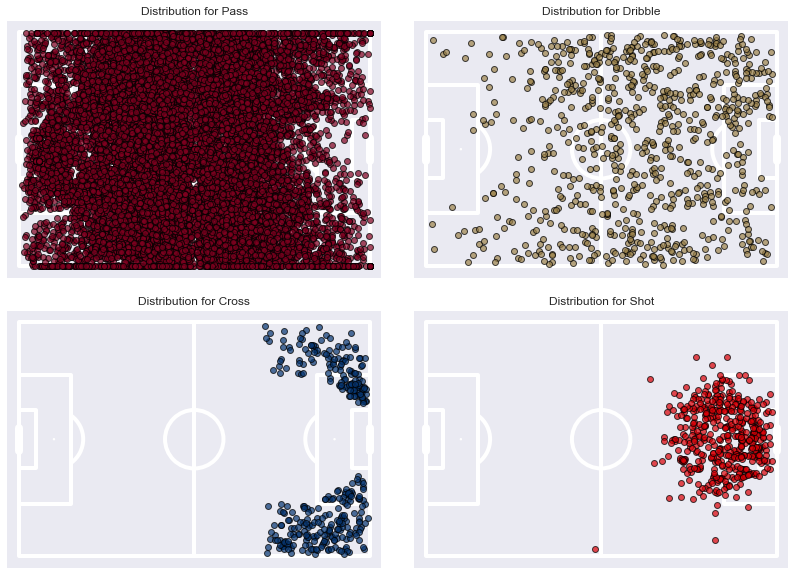

In [11]:
pitch = Pitch(linewidth=4)
fig, axs = pitch.grid(nrows=2, ncols=2,  # number of rows/ columns
                      figheight=8,  # the figure height in inches
                      bottom=0.025,  # starts 2.5% in from the figure bottom
                      # increased the grid_height as no title/ endnote
                      # now it takes up 95% of the figheight
                      grid_height=0.95,
                      grid_width=0.95,  # the grid takes up 95% of the figwidth
                      # 6% of the grid_height is the space between pitches.
                      space=0.06,
                      # set the endnote/title height to zero so
                      # they are not plotted. note this automatically
                      # sets the endnote/title space to zero
                      # so the grid starts at the bottom/left location
                      endnote_height=0, title_height=0)

for idx, color, action, action_df, ax in zip(
    range(4),
    ['#800020', '#9C824A', '#063672', '#DB0007'],
    ['Pass', 'Dribble', 'Cross', 'Shot'],
    [pass_df, dribble_df, cross_df, shot_df],
    axs['pitch'].flat):
    
    # if action == 'Shot': scale = action_df['shot_statsbomb_xg'] * 200
    # else: scale = None
    
    pitch.scatter(
        action_df['location_x'],
        action_df['location_y'],
        c=color,
        alpha=0.7,
        ec='black',
        ax=ax
        )
    
    ax.set_title(f'Distribution for {action}')

plt.show()